## How to use UpTrain to experiment with multiple prompts

**Overview**: In this example, we will see how to experiment with multiple prompts using UpTrain, to select which one works best for the given use case. The experimentation is done by defining multiple prompt templates along with a test dataset, utilizing UpTrain to compute model responses for them, and running a variety of evaluations to compare them quantitatively. We will use a Q&A task as an example to highlight the same.

**Why Evaluate Prompts**: LLM outputs are highly sensitive to the prompt provided. Trivial changes to the prompt such as assigning a personality to the LLM by prefixing the prompt with "Imagine you are a CEO/Writer/Scientist etc." can generate widely different responses. This difference impacts the overall application's performance, making it crucial to test multiple prompts over cases to find the one best suited for the application.

**Problem**: The workflow of our hypothetical Q&A application goes like this,
- The user enters a question. 
- The question is converted to a vector encoding.
- Relevant sections from the documentation are retrieved using a vector database. 
- The question and the retrieved sections are inserted into a custom prompt and passed to a language model (LM) to generate a response. 

The goal is to find the best prompt which answers the user's question.

**Solution**: In the given tutorial, we consider a prompt template with LLM_PERSONALITY as a variable and use the experimentation framework to find the best personality to fill in. We demonstrate how to use the Uptrain framework to first obtain output responses for a test set of queries. We then evaluate the quality of the responses on some specified metrics.

## Install UpTrain with all dependencies

```bash
pip install uptrain
uptrain-add --feature full
```

In [1]:
import os
import tempfile

import polars as pl
from loguru import logger

logger.remove() # if you are getting errors, comment this line out and retry
TEMP_DIR = tempfile.gettempdir()


**This notebook uses the OpenAI API to generate text for prompts, make sure the env variable is populated with the API key.**

In [2]:
# os.environ["OPENAI_API_KEY"] = "..."


# Let's first define our prompts and model

We have designed a prompt template to take in a question and a document and answer the question asked by the user.

In [3]:
prompt_base = """
    You are a {LLM_PERSONALITY}. Answer the following user query using the retrieved document:
    {question}
    The retrieved document titled "{document_title}" has the following text:
    {document_text}
"""


As we see from the above prompt, we have an additional variable in our prompt called "LLM_PERSONALITY". We want to experiment with multiple personalities like **("bot", "backend developer", "python expert")** and check which of the three gives the most appropriate response.

Just for clarity, let's see what these prompts look like:

In [4]:
print("prompt_bot: ", prompt_base.replace("{LLM_PERSONALITY}", "bot"))
print("prompt_developer: ", prompt_base.replace("{LLM_PERSONALITY}", "backend developer"))
print("prompt_expert: ", prompt_base.replace("{LLM_PERSONALITY}", "python expert"))


prompt_bot:  
    You are a bot. Answer the following user query using the retrieved document:
    {question}
    The retrieved document titled "{document_title}" has the following text:
    {document_text}

prompt_developer:  
    You are a backend developer. Answer the following user query using the retrieved document:
    {question}
    The retrieved document titled "{document_title}" has the following text:
    {document_text}

prompt_expert:  
    You are a python expert. Answer the following user query using the retrieved document:
    {question}
    The retrieved document titled "{document_title}" has the following text:
    {document_text}



Let's now load our dataset and see how that looks

In [5]:
url = "https://oodles-dev-training-data.s3.us-west-1.amazonaws.com/qna-streamlit-docs.jsonl"
dataset_path = os.path.join(TEMP_DIR, "qna-notebook-data.jsonl")

if not os.path.exists(dataset_path):
    import httpx

    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)

dataset = pl.read_ndjson(dataset_path).select(
    pl.col(["question", "document_title", "document_text"])
)
print("Number of test cases: ", len(dataset))
print("Couple of samples: ", dataset[0:2])


Number of test cases:  90
Couple of samples:  shape: (2, 3)
┌─────────────────────────────┬──────────────────────────────┬─────────────────────────────────────┐
│ question                    ┆ document_title               ┆ document_text                       │
│ ---                         ┆ ---                          ┆ ---                                 │
│ str                         ┆ str                          ┆ str                                 │
╞═════════════════════════════╪══════════════════════════════╪═════════════════════════════════════╡
│ How to use the sessionstate ┆ What is serializable session ┆ ## Serializable Session State\n\…   │
│ feat…                       ┆ sta…                         ┆                                     │
│ How can I create histograms ┆ API reference                ┆ ader(\"Define a custom colorscal…   │
│ with…                       ┆                              ┆                                     │
└─────────────────────────────┴

# Using UpTrain Framework to compare multiple prompts

We start by configuring UpTrain to run our experiment. We will be using OpenAI's GPT-3.5-Turbo as our LLM. 

Let's define an UpTrain 'Settings' object which has the directory location where we want to save the results of this experiment. Note that you must have `OPENAI_API_KEY` specified in your env variables or specify it explicitly in the `Settings` object. 

In [6]:
from uptrain.framework import Settings

UPTRAIN_LOGS_DIR = os.path.join(TEMP_DIR, "uptrain_prompt_experiments")
os.makedirs(UPTRAIN_LOGS_DIR, exist_ok=True)

UPTRAIN_SETTINGS = Settings(logs_folder=UPTRAIN_LOGS_DIR)


### Compute LLM responses for all the three prompts

Now that we have multiple prompts, let's define our checks to compare which one performs best. As our prompt explicitly asks the LLM to answer the given question using sections from document text only, we are defining a hallucination check which uses [Rouge score](https://en.wikipedia.org/wiki/ROUGE_(metric)) between the input document text and LLM response.

In [7]:
from uptrain.framework import Check, CheckSet
from uptrain.operators import Histogram, Table, RougeScore

hallucination_check = Check(
    name="hallucination",
    operators=[
        RougeScore(
            col_in_generated="exp_generated",
            col_in_source="document_text",
            score_type="precision",
            col_out="overlap_score",
        ),
    ],
    plots=[
        Histogram(
            props=dict(x="overlap_score", nbins=20, color="exp_LLM_PERSONALITY")
        ),
        Table(title="Hallucination scores"),
    ],
)


To create multiple prompts from the same prompt template, UpTrain provides a PromptExperiment class where one can define their prompt template, multiple parameters to generate different prompt variations and the LLM model to be used. 

In [8]:
from uptrain.operators import JsonReader, PromptGenerator, TextCompletion

check_set = CheckSet(
    source=JsonReader(fpath=dataset_path),
    preprocessors=[
        PromptGenerator(
            prompt_template=prompt_base,
            prompt_params={
                "LLM_PERSONALITY": ["bot", "backend developer", "python expert"]
            },
            models=["gpt-3.5-turbo"],
            context_vars=["question", "document_title", "document_text"],
        ),
        TextCompletion(
            col_in_prompt="exp_prompt",
            col_in_model="exp_model",
            col_out_completion="exp_generated",
        ),
    ],
    checks=[hallucination_check],
)


Now we run the `CheckSet` and see which prompts perform best.

In [9]:
check_set.setup(UPTRAIN_SETTINGS).run()


100%|██████████| 270/270 [00:26<00:00, 10.27it/s]


We can now start the Streamlit dashboard to visualize the evaluation results. 

In [10]:
from uptrain.dashboard import StreamlitRunner

runner = StreamlitRunner(UPTRAIN_LOGS_DIR)
runner.start()


### Visualizing the evaluation results

UpTrain offers pivoting options for tables. Here, we use this to find out which of the three personalities has the highest overlap scores.

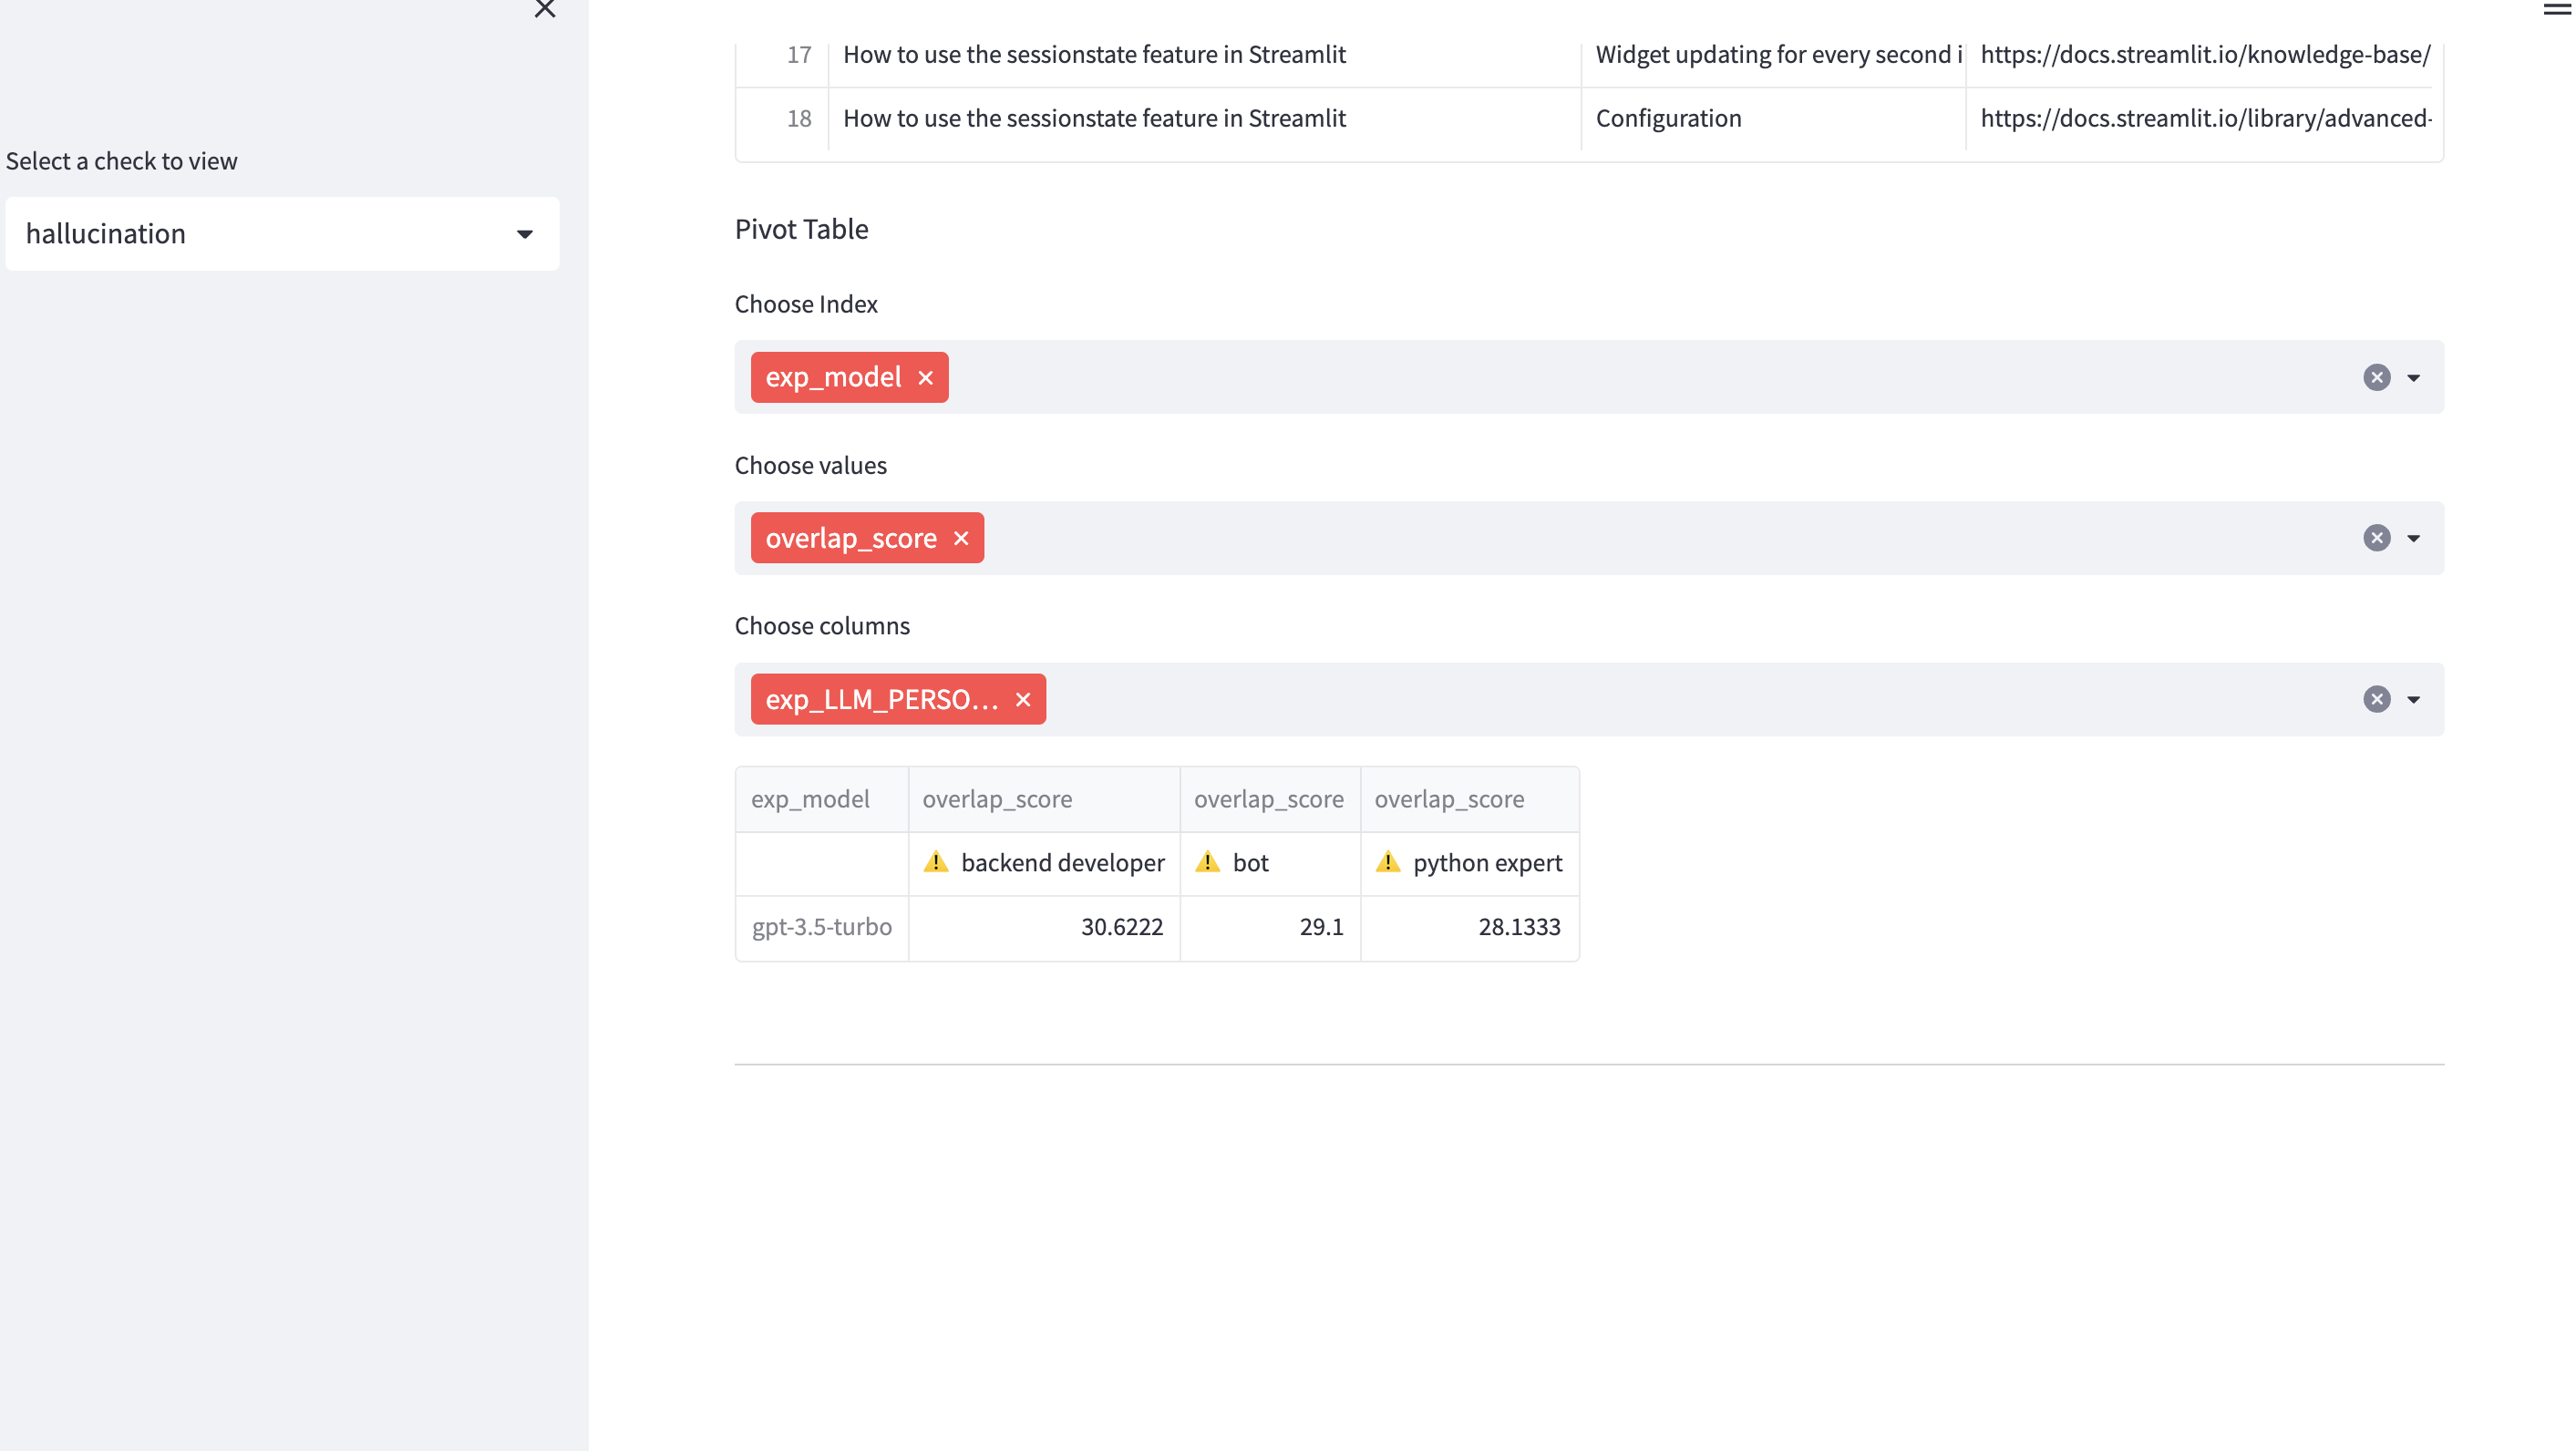

Alternatively, we could look at the distribution of hallucination scores across different prompt parameters. 

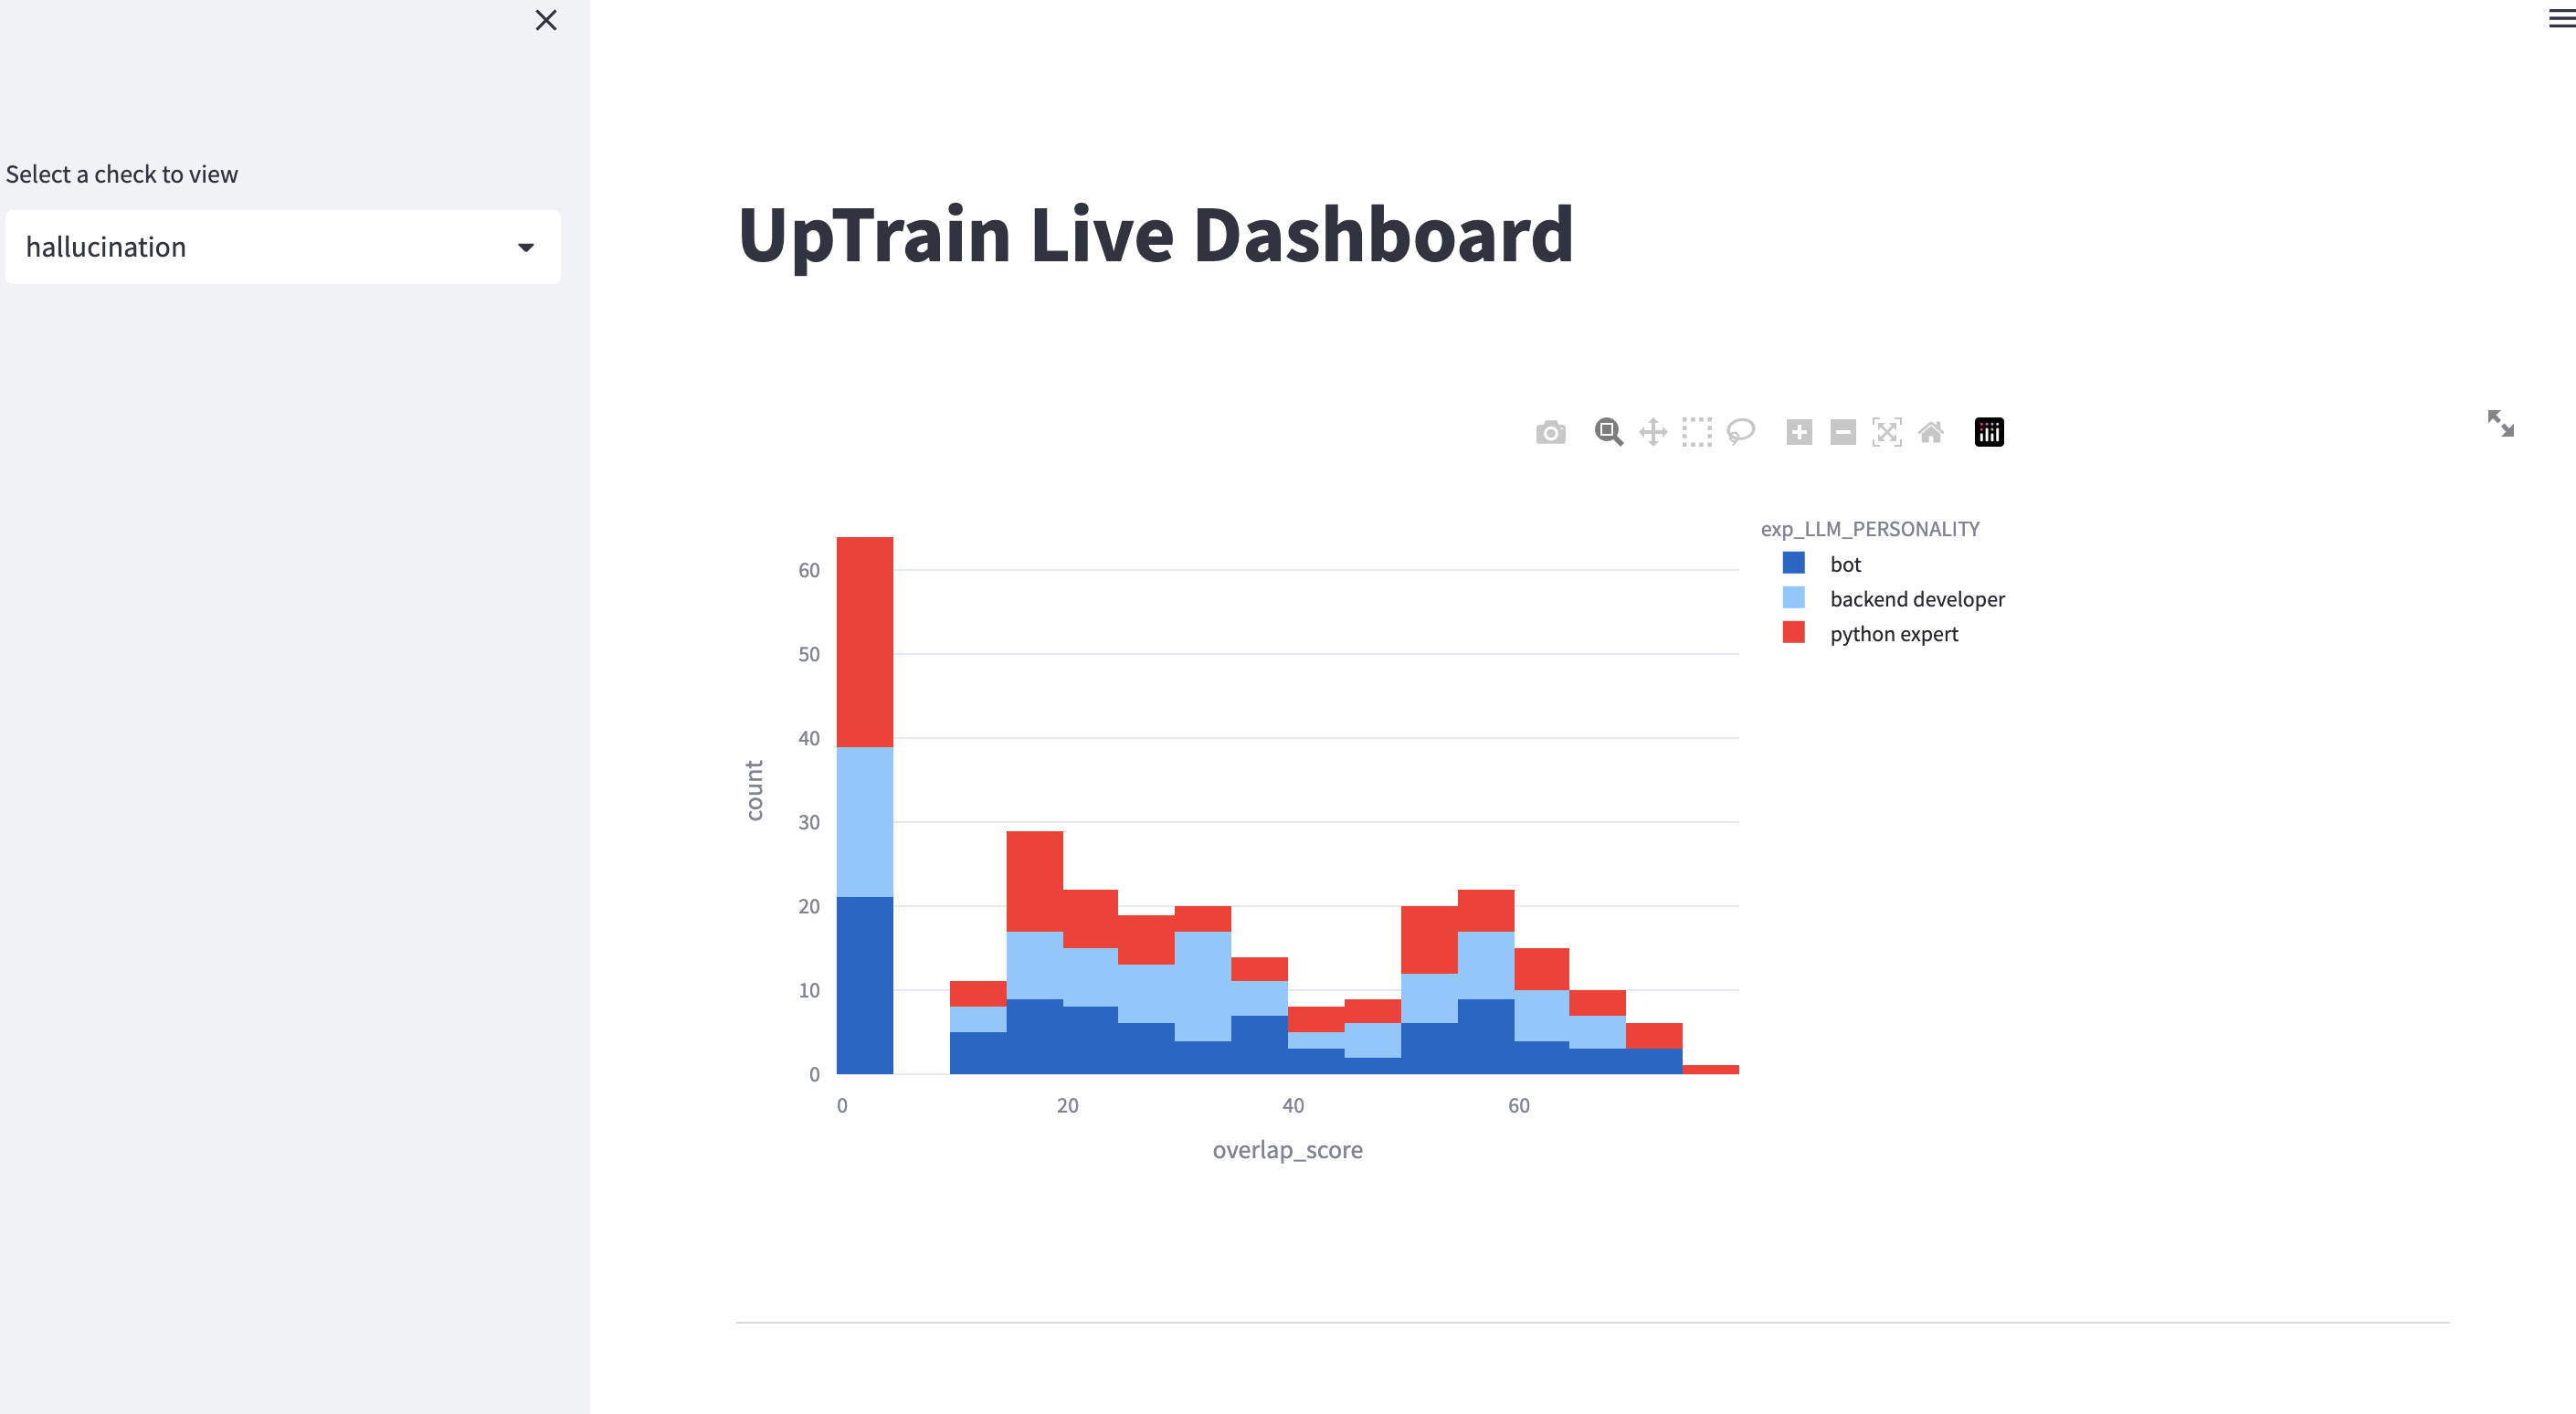